In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Задание 7 (2 балла)
Вам предлагается реализовать алгоритм аппроксимации функции синус с помощью метода [МНК](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2)

$$f(x)=sin(x), x \in [-180, 180]$$

* Вам необходимо будет аппроксимировать функцию на этом отрезке.
* Сформировать обучающее и тестовое множества самостоятельно.
* Использовать готовую реализацию из numpy в пунктах 1 и 2 - нельзя.
* Оценку времени выполнять из 10 запусков.
* При построении графиков, вам необходимо учитывать все 10 запусков (отразить дисперсию, "график с трубой")
* Кроссвалидацию делать необязательно
* Помните про радианы и градусы


#### 0. Создайте данные для решения задачи (0,1)

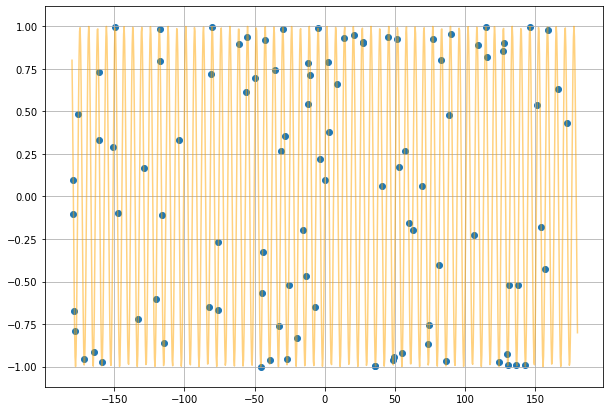

In [2]:
n = 100
sample = np.random.rand(n) * 360 - 180
sample = np.vstack((sample, np.sin(sample))).T
plt.figure(figsize=(10,7))
plt.grid()
gr = np.linspace(-180, 180, 1000)
plt.plot(gr, np.sin(gr), color = 'orange', alpha=0.5)
plt.scatter(sample[:,0], sample[:,1])

#### 1. Реализуйте МНК с помощью numpy (0,2)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

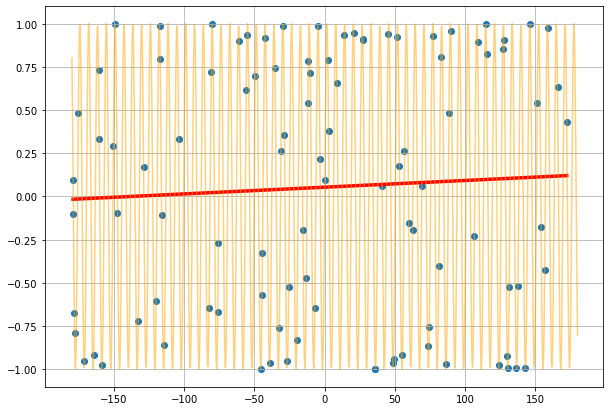

In [3]:
def common_lstsq(sample):
    n = sample.shape[0]
    X = np.vstack((sample[:,0], np.ones(n))).T
    y = sample[:,1]
    return np.linalg.inv(X.T @ X) @ X.T @ y
    
    
a, b = common_lstsq(sample)
x = sample[:,0]
y = sample[:,1]
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(x), a * np.sort(x) + b, color='red', linewidth=3.5)
plt.scatter(x, y)
plt.plot(gr, np.sin(gr), color = 'orange', alpha=0.5)

#### 2. Реализуйте МНК с помощью numpy и cdef (0,3)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

In [4]:
%load_ext Cython

In [5]:
%%cython --annotate
cimport numpy as np
from numpy import vstack, ones, linalg

def lstsq_with_cython(sample):
    cdef int n = sample.shape[0]
    cdef np.ndarray X = vstack((sample[:,0], ones(n))).T
    cdef np.ndarray y = sample[:,1]
    return linalg.inv(X.T @ X) @ X.T @ y

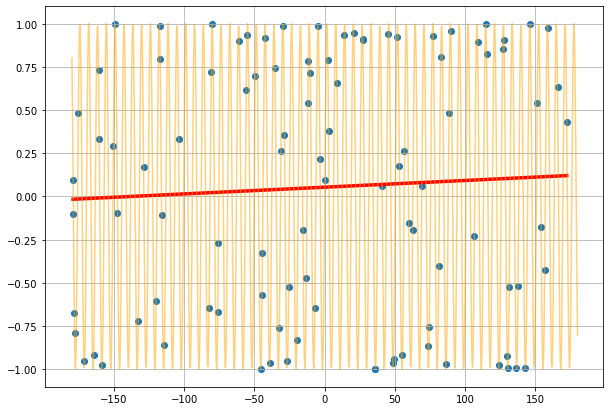

In [6]:
%%cython
from __main__ import lstsq_with_cython
from __main__ import plt, sample, gr, np

a, b = lstsq_with_cython(sample)
x = sample[:,0]
y = sample[:,1]
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(x), a * np.sort(x) + b, color='red', linewidth=3.5)
plt.scatter(x, y)
plt.plot(gr, np.sin(gr), color = 'orange', alpha=0.5)

#### 3. Реализуйте МНК с помощью c extensions (0,4)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

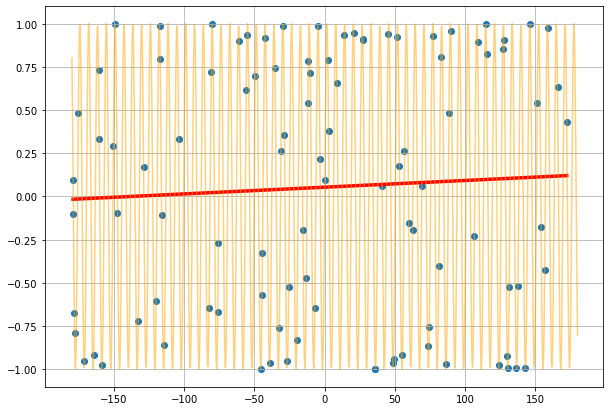

In [7]:
import lstsq_ext

a, b = lstsq_ext.lstsq(sample)
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(x), a * np.sort(x) + b, color='red', linewidth=3.5)
plt.scatter(x, y)
plt.plot(gr, np.sin(gr), color = 'orange', alpha=0.5)

#### 4. Сравните время работы (0,1)
Сравните время работы реализаций из пунктов "1. Реализуйте МНК с помощью numpy", "2. Реализуйте МНК с помощью numpy и cdef" и "3. Реализуйте МНК с помощью c extensions"

In [8]:
%%timeit
a, b = common_lstsq(sample)

25.6 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
a, b = lstsq_with_cython(sample)

23.7 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%timeit
a, b = lstsq_ext.lstsq(sample)

23.5 µs ± 771 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### 5. Сделайте выводы по полученным оценкам времени (0,3):
В частности, ответить на вопросы:
1. Увеличилось ли время при использовании cdef в сравнении с numpy? - Почему? **(0,1)**
2. Как влияет c extensions на производительность? **(0,1)**
3. Сравните c extensions и вашу numpy реализацию. **(0,1)**

1. Несколько запусков кода показали, что время уменьшилось ~ на 1 микросекунду, то есть никакого ощутимого прироста или замедления нет. Думаю, это связано с тем что большинство операций моей функции происходят в `numpy` который и так `C`-оптимизирован.
2. Влияет очень слабо. Скорее всего основных аргументов здесь два - отсуствие каких-либо циклов, которые могли быть оптимизированы типизацией из `C` и уже упомянутая оптимизированность `numpy`.
3. Практически не отличаются. Но в большинстве экспериментах функция из `C extension` быстрее обычной питоновской реализации на 1-2 микросекунды.

(Возможно, в задании подразумевалось написать МНК на чистом `C`, после чего включить его в `Python` код, но в лекции такого примера не было :c)

#### 6. Сделайте профилирование (0,4)
1. Сделайте профилирование реализации из пункта 1, можно ли как-то ускорить? **(0,2)**
1. Сделайте профилирование реализации из пункта 2, можно ли как-то ускорить? **(0,2)**

In [11]:
import cProfile, pstats, io

pr = cProfile.Profile()
pr.enable()
a, b = common_lstsq(sample)
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         85 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3288(run_code)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <ipython-input-11-5aee378e4ad5>:5(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-3-6c83ece7bac1>:1(common_lstsq)
        1    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:486(inv)
        1    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\shape_base.py:229(vstack)
        2    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\codeop.py:132(__call__)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.00

In [12]:
pr = cProfile.Profile()
pr.enable()
a, b = lstsq_with_cython(sample)
pr.disable()
s = io.StringIO()
sortby = 'cumulative'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         85 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3288(run_code)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <ipython-input-12-5e5a8a570443>:3(<module>)
        1    0.000    0.000    0.000    0.000 {_cython_magic_2498bc20ca24764a890502f6d29924ce.lstsq_with_cython}
        1    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:486(inv)
        2    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\codeop.py:132(__call__)
        1    0.000    0.000    0.000    0.000 C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\shape_base.py:229(vstack)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
      

К сожалению, из такого вывода профайлера можно сделать только вывод о невозможности как либо ускорить код - ни один вызов функции не занимает времени даже порядка микросекунды.

#### 7. Используйте готовую реализацию МНК из numpy / scipy (0,1)
Протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию.

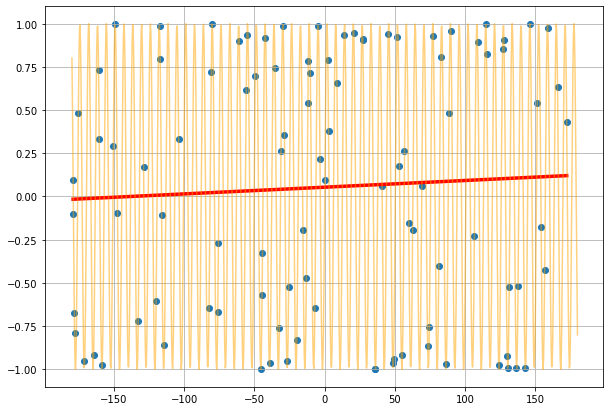

In [13]:
n = sample.shape[0]
X = np.vstack((sample[:,0], np.ones(n))).T
y = sample[:,1]
a, b = np.linalg.lstsq(X, y, rcond=None)[0]
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(X[:,0]), a * np.sort(X[:,0]) + b, color='red', linewidth=3.5)
plt.scatter(X[:,0], y)
plt.plot(gr, np.sin(gr), color = 'orange', alpha=0.5)

In [14]:
%%timeit

a, b = np.linalg.lstsq(X, y, rcond=None)[0]

35.6 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


#### 8. Выводы (0,1)
Резюмируйте и сделайте выводы относительно проведенных экспериментов

Выбранный способ реализации МНК с помощью `numpy` точно является одним из самых оптимальных - он оптимальнее встроенной в `numpy` функции (умолчим тот факт, что возможностей у неё больше, чем подбор коэффициентов линейной регрессии).

Также заметно, что `cython` и `c extension` дают прирост в скорости, но на этом эксперименте это наблюдать трудно. Думаю, более показательным будет провести аналогичные эксперименты на функциях с явными циклами, где аннотация переменных даст _существенный_ прирост в скорости.